In [2]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

## Introduction

For my notebook I wanted to look at price prediction for Bitcoin from a historical price dataset I found on Kaggle using an ARIMA model I found someone use on a subset of this data and I did it for the full dataset.  We will predict the Bitcoin price by month but we will make it so we could observe it yearly, quarterly, or daily as well.

In [3]:
## Load the data, clean the data, look at the first 5 observations, and then I created a correlation matrix between all the 
## variables.


rawdata = pd.read_csv('/Users/ethanmeersman/bitcoin.csv')


## Drop's the N/A's to clean the data
df = rawdata.dropna()
## Resets index so the data columns reset after dropping the N/A's
df.reset_index(inplace=True, drop=True)
## Changes Timestamp variable to read it in normal time and not UNIX timestamps.
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
## Top 5 records of cleaned data
df.head(5)
df.corr()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Open,1.000000,0.999999,0.999999,0.999999,-0.051860,0.344074,0.999999
High,0.999999,1.000000,0.999998,0.999999,-0.051717,0.344498,0.999999
Low,0.999999,0.999998,1.000000,0.999999,-0.052040,0.343541,1.000000
Close,0.999999,0.999999,0.999999,1.000000,-0.051877,0.344036,1.000000
Volume_(BTC),-0.051860,-0.051717,-0.052040,-0.051877,1.000000,0.352038,-0.051887
Volume_(Currency),0.344074,0.344498,0.343541,0.344036,0.352038,1.000000,0.344010
Weighted_Price,0.999999,0.999999,1.000000,1.000000,-0.051887,0.344010,1.000000


In [4]:
# Unix-time to regular formatting
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')

# Daily
df.index = df.Timestamp
df = df.resample('D').mean()

# Monthly
df_month = df.resample('M').mean()

# Yearly
df_year = df.resample('A-DEC').mean()

# Quarterly
df_Q = df.resample('Q-DEC').mean()

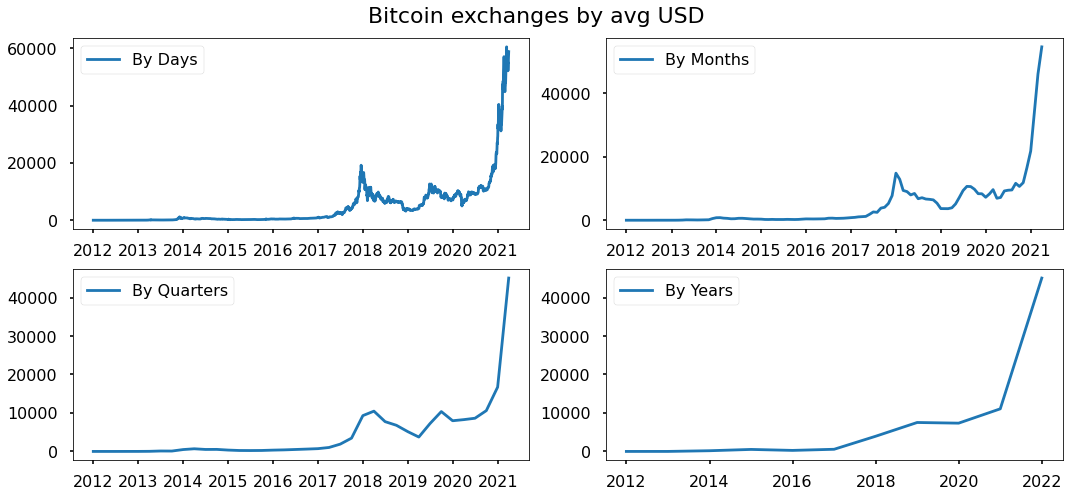

In [5]:
# Plots of each different time frame
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges by avg USD', fontsize=22)

plt.subplot(221)
plt.plot(df.Weighted_Price, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.Weighted_Price, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Weighted_Price, '-', label='By Years')

plt.legend()
plt.tight_layout()
plt.show()

Dickey–Fuller test: p=0.998863


<Figure size 1080x504 with 0 Axes>

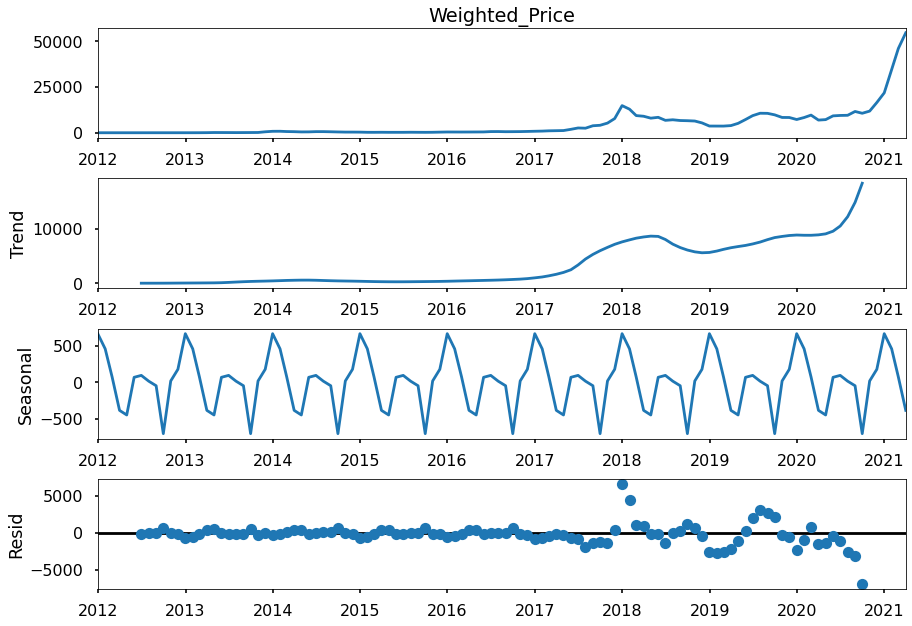

In [6]:
## This test is to determine whether it is stationary or not and this data is not sationary so I need to fix that

plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Weighted_Price).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])
plt.show()

In [7]:
# Box-Cox Transformations

df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.Weighted_Price)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])

## This is still non-stationary

Dickey–Fuller test: p=0.998863


In [8]:
# Seasonal differentiation

df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

## Getting more stationary but not where I want it yet it should be below .05 

Dickey–Fuller test: p=0.444282


Dickey–Fuller test: p=0.000024


<Figure size 1080x504 with 0 Axes>

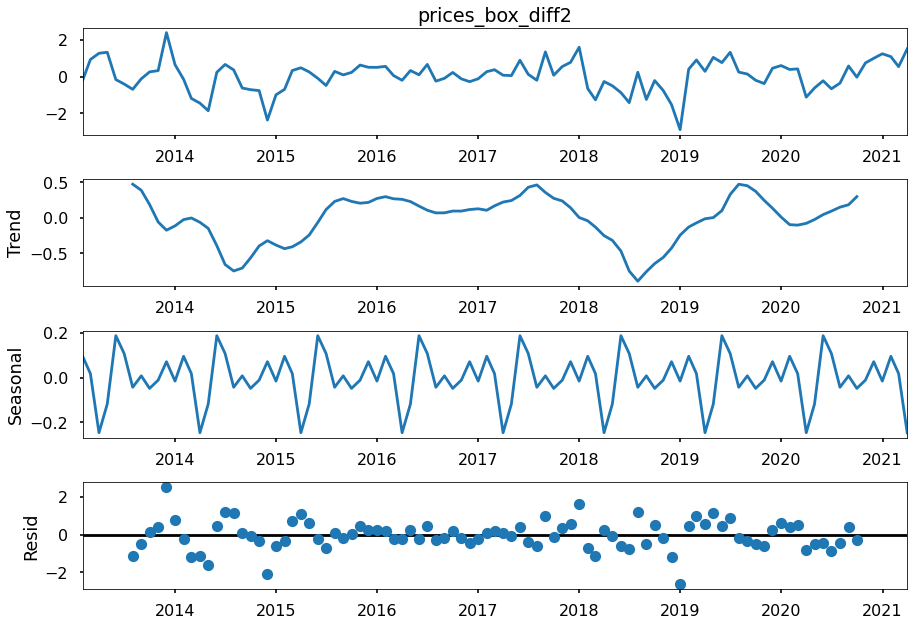

In [9]:
# Regular differentiation

df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition

sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

## This is stationary after the decomposition 

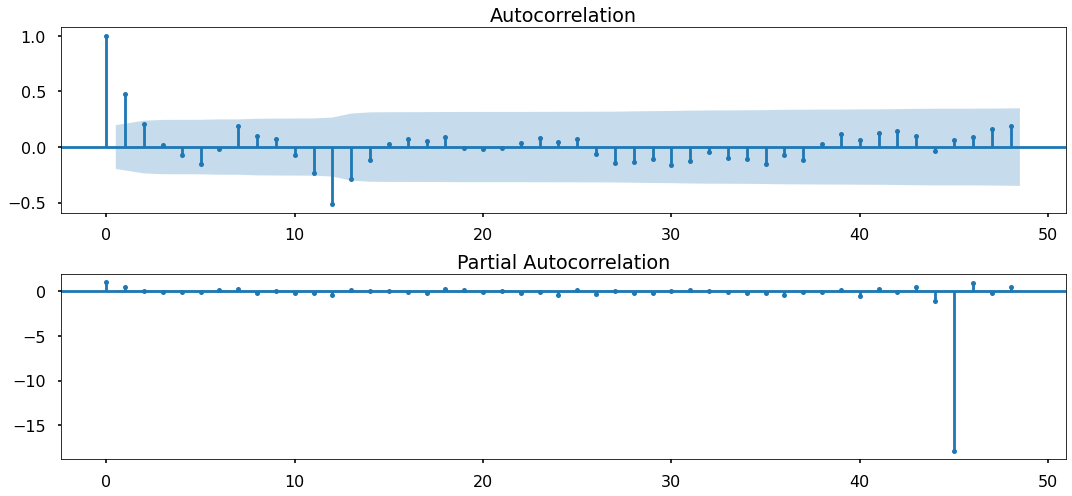

In [10]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots

plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

## 1 lag spike at the beginning is what we look for in an autocorrelation plot to consider how many differences 
## need in the data for it to be significant.  You also look for decay in these spikes like in the first plot and 
## in the second plot there is one at the end which is a good thing.

In [ ]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [11]:
# Best Models

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
19  (1, 0, 0, 1)  173.616065
21  (1, 0, 1, 1)  174.766385
25  (1, 1, 0, 1)  175.547531
37  (2, 0, 0, 1)  175.554029
7   (0, 1, 0, 1)  175.589231
                                      SARIMAX Results                                       
Dep. Variable:                   Weighted_Price_box   No. Observations:                  112
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 -83.808
Date:                              Tue, 27 Jul 2021   AIC                            173.616
Time:                                      23:03:51   BIC                            181.401
Sample:                                  12-31-2011   HQIC                           176.766
                                       - 03-31-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---

## Results

Ljung-Box is less than .05 meaning that there is autocorrelation and the model is valid in this case.  

Dickey–Fuller test:: p=0.000000


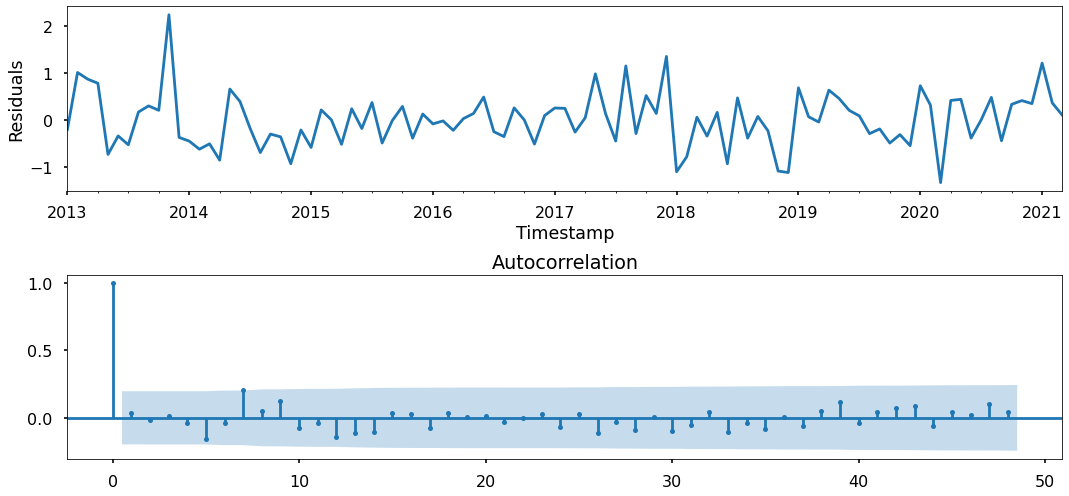

In [39]:
# STL-decomposition

plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

## Below you can see that the Dickey-Fuller test is below .05 so it is stationary and the model selection was  
## successful after decomposition.

In [40]:
# Inverse Box-Cox Transformation Function

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

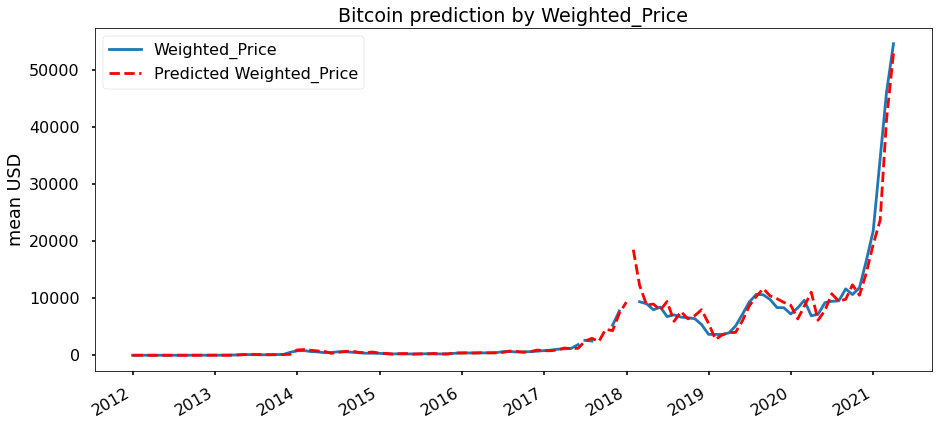

In [41]:
# Prediction
df_month2 = df_month[['Weighted_Price']]
date_list = [datetime(2017, 6, 30), datetime(2017, 7, 31), datetime(2017, 8, 31), datetime(2017, 9, 30), 
             datetime(2017, 10, 31), datetime(2017, 11, 30), datetime(2017, 12, 31), datetime(2018, 1, 31),
             datetime(2018, 1, 28)]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=150), lmbda)
plt.figure(figsize=(15,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin prediction by Weighted_Price')
plt.ylabel('mean USD')
plt.show()

## References 

https://www.kaggle.com/mczielinski/bitcoin-historical-data

https://www.kaggle.com/myonin/bitcoin-price-prediction-by-arima/execution

I used the full dataset in the first link and used the model in the second link  (they only used a subset of the whole dataset) and some of my R code from an Economic Forecasting class I took last semester to create this entire model.